In [ ]:
# !pip install transformers
# !pip install scikit-learn
# !pip install accelerate
# !pip uninstall bitsandbytes
# !pip install -i https://test.pypi.org/simple/ bitsandbytes
# !pip install matplotlib

In [68]:
import os
import gc
import time
import random
import torch
import numpy as np
from PIL import Image
from transformers import AutoProcessor, Blip2Processor, Blip2Model, Blip2ForConditionalGeneration
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2Model.from_pretrained("Salesforce/blip2-opt-2.7b", \
                                                      load_in_8bit=True, \
                                                      device_map="auto", \
                                                      max_memory={0: "8GiB",  1: "24GiB",})

Overriding torch_dtype=None with `torch_dtype=torch.float16` due to requirements of `bitsandbytes` to enable model loading in mixed int8. Either pass torch_dtype=torch.float16 or don't pass this argument at all to remove this warning.



===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /nas/home/syjoshi/miniconda3/envs/imkg/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda118.so
CUDA SETUP: CUDA runtime path found: /nas/home/syjoshi/miniconda3/envs/imkg/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 118
CUDA SETUP: Loading binary /nas/home/syjoshi/miniconda3/envs/imkg/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda118.so...


/nas/home/syjoshi/miniconda3/envs/imkg/lib/python3.8/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: Found duplicate ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] files: {PosixPath('/nas/home/syjoshi/miniconda3/envs/imkg/lib/libcudart.so'), PosixPath('/nas/home/syjoshi/miniconda3/envs/imkg/lib/libcudart.so.11.0')}.. We'll flip a coin and try one of these, in order to fail forward.
Either way, this might cause trouble in the future:
If you get `CUDA error: invalid device function` errors, the above might be the cause and the solution is to make sure only one ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] in the paths that we search based on your env.
  warn(msg)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
img_dir = "data/memes/1fbmt7d9n11b1.png"
img = Image.open(img_dir)

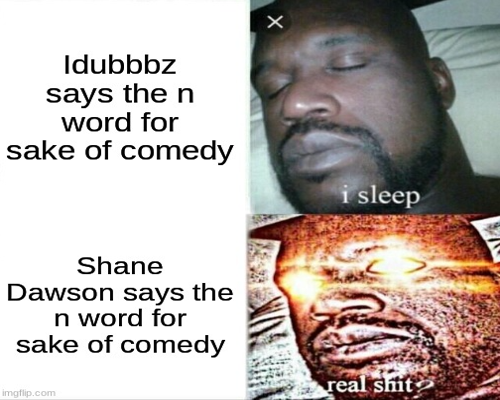

In [4]:
raw_image = Image.open(img_dir).convert("RGB")
display(raw_image.resize((500, 400)))

In [5]:
inputs = processor(img, return_tensors="pt").to(0, torch.float16)

In [6]:
out = model.get_image_features(**inputs)

In [7]:
print(out)

BaseModelOutputWithPooling(last_hidden_state=tensor([[[-0.3689, -0.8198, -0.1605,  ...,  0.4680, -0.0373,  0.7002],
         [-0.4194,  0.8774,  0.9004,  ..., -0.9951, -0.6328, -0.7944],
         [-0.8579,  0.5933,  0.9673,  ...,  0.3081, -1.4004,  0.1216],
         ...,
         [ 2.3125,  0.9937, -0.1472,  ..., -1.2793,  0.6440,  1.5459],
         [-0.5225, -0.4270,  1.2725,  ..., -0.3711, -1.4248,  1.5000],
         [-0.6660,  1.6924,  0.4771,  ..., -0.5806, -0.5200,  0.7700]]],
       device='cuda:0', dtype=torch.float16, grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-1.0859, -2.1426, -0.5776,  ...,  0.6235, -0.0099,  1.7676]],
       device='cuda:0', dtype=torch.float16, grad_fn=<NativeLayerNormBackward0>), hidden_states=None, attentions=None)


In [8]:
# img_dir = "./data/memes"
# img_features = []
# for file in tqdm(os.listdir(img_dir)):
#     if file.endswith(".jpg") or file.endswith(".png"):
#         file_path = os.path.join(img_dir, file)
#         img = Image.open(file_path)
#         inputs = processor(images=img, return_tensors="pt").to(device, torch.float16)
#         img_outputs = model.get_image_features(**inputs)
#         img_tensor = img_outputs.last_hidden_state
#         img_features.append(img_tensor)
#         del inputs, img_outputs, img_tensor


root_dir = "./data/"
dirs = ["CoronavirusMemes", "dank_meme", "dankmeme", \
        "funny", "memes"]
all_images = []
for _dir in dirs:
    files = os.listdir(root_dir+_dir)
    jpg_files = [file for file in files if file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg")]
    random_images = random.sample(jpg_files, 5)
    for image in random_images:
        image = root_dir+_dir+'/'+image
        all_images.append(image)

# print(all_images)
img_features = []
batch_size = 1
for i in tqdm(range(0, len(all_images), batch_size)):
    batch_files = all_images[i:i+batch_size]
    batch_images = []
    for file in batch_files:
        if file.endswith(".jpg") or file.endswith(".png") or file.endswith(".jpeg"):
            file_path = file
            img = Image.open(file_path)
            batch_images.append(img)
    batch_inputs = processor(batch_images, return_tensors="pt").to(0, torch.float16)
    batch_outputs = model.get_image_features(**batch_inputs)
    batch_tensor = batch_outputs.last_hidden_state
    img_features.append(batch_tensor)
    gc.collect()
    del batch_inputs, batch_outputs 
    time.sleep(10)
    torch.cuda.empty_cache()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [04:23<00:00, 10.56s/it]


In [26]:
features = torch.cat(img_features, dim=0)

In [28]:
num_samples = len(img_features)
features = features.reshape(num_samples, -1)
features_np = features.detach().cpu().numpy()

In [57]:
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_np)

  0%|                                                                                                                                                           | 0/9 [00:00<?, ?it/s]/nas/home/syjoshi/miniconda3/envs/imkg/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/nas/home/syjoshi/miniconda3/envs/imkg/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/nas/home/syjoshi/miniconda3/envs/imkg/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/nas/home/syjoshi/miniconda3/envs/imkg

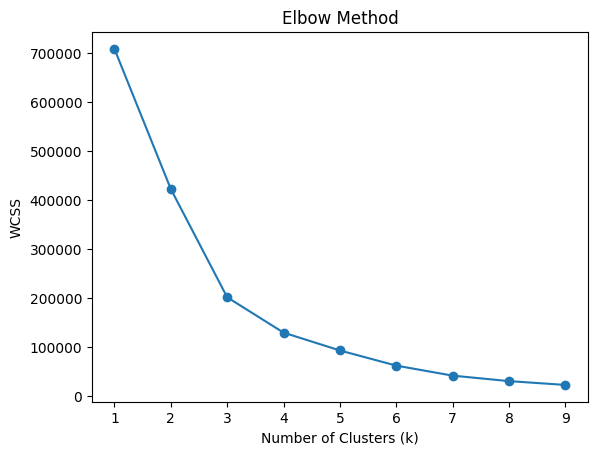

In [72]:
wcss = []
k_vals = range(1,10)
for k in tqdm(k_vals):
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(features_pca)
    wcss.append(kmeans.inertia_)
    
plt.plot(k_vals, wcss, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

In [73]:
k = 3
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(features_pca)

/nas/home/syjoshi/miniconda3/envs/imkg/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=0)

In [74]:
cluster_labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

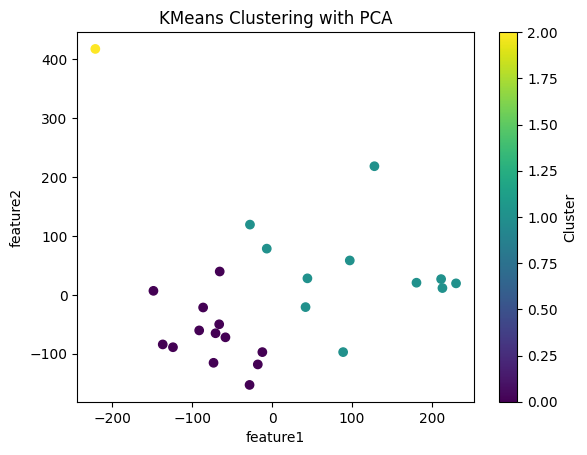

In [75]:
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.xlabel('feature1')
plt.ylabel('feature2')
plt.title('KMeans Clustering with PCA')
plt.colorbar(label='Cluster')
plt.show()

In [95]:
cluster0 = {}
cluster1 = {}
cluster2 = {}
c0 = []
c1 = []
c2 = []
for x, y in zip(all_images, cluster_labels):
    if y == 0:
        c0.append(x)
    elif y == 1:
        c1.append(x)
    elif y == 2:
        c2.append(x)

def img_cluster(cluster, c):
    for x in c:
        y = x.split('/')[-2]
        if y not in cluster:
            cluster[y] = 0
        cluster[y] += 1
    return cluster

def bar_plot(cluster, num):
    keys = list(cluster.keys())
    values = list(cluster.values())
    plt.bar(keys, values)
    plt.xlabel('Subreddit')
    plt.ylabel('Values')
    plt.title('Cluster '+str(num))
    plt.show()
    
def subplots(img_list):
    c = 3
    r = len(img_list) // c
    r += (len(img_list) % cols > 0)
    fig, axes = plt.subplots(r, c, figsize=(10, 10))
    axes = axes.flatten()
    for i, img_name in enumerate(img_list):
        img = plt.imread(img_name)
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(image_name)
    for j in range(len(img_list), len(axes)):
        axes[j].axis('off')
    plt.tight_layout()
    plt.show()

cluster0 = img_cluster(cluster0, c0)
cluster1 = img_cluster(cluster1, c1)
cluster2 = img_cluster(cluster2, c2)

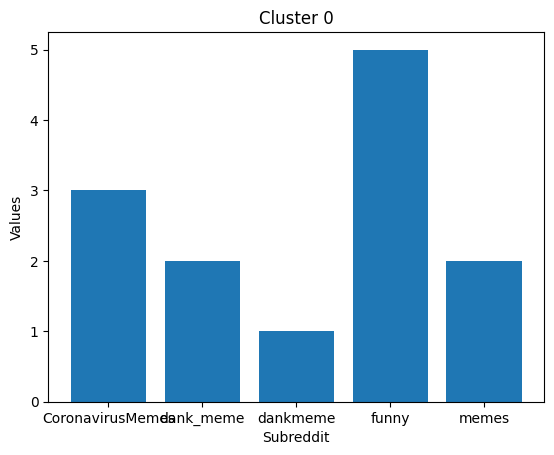

In [96]:
bar_plot(cluster0, 0)

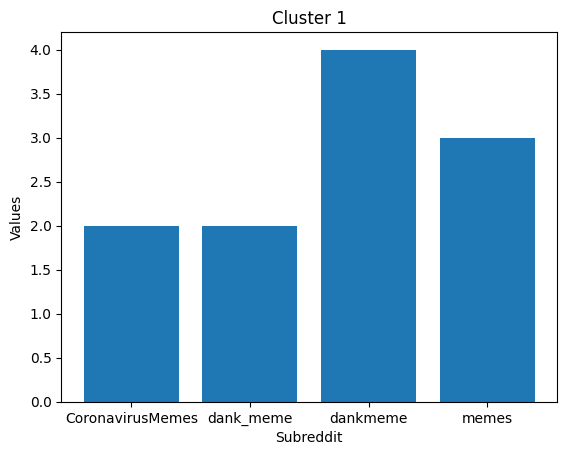

In [97]:
bar_plot(cluster1, 1)

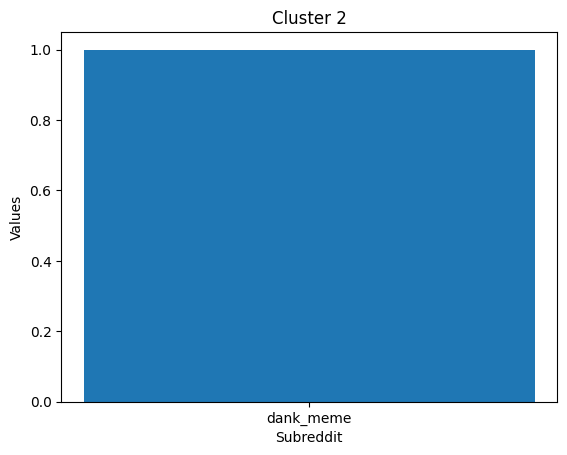

In [98]:
bar_plot(cluster2, 2)

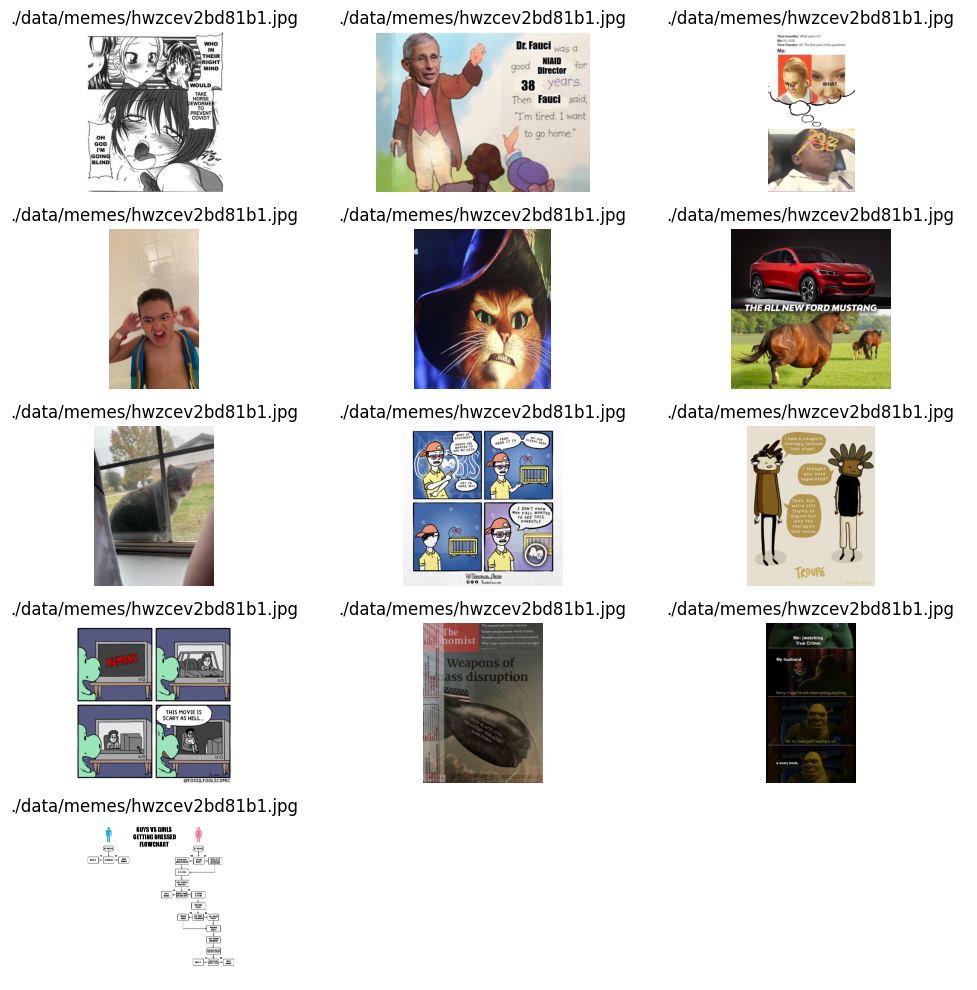

In [99]:
subplots(c0)

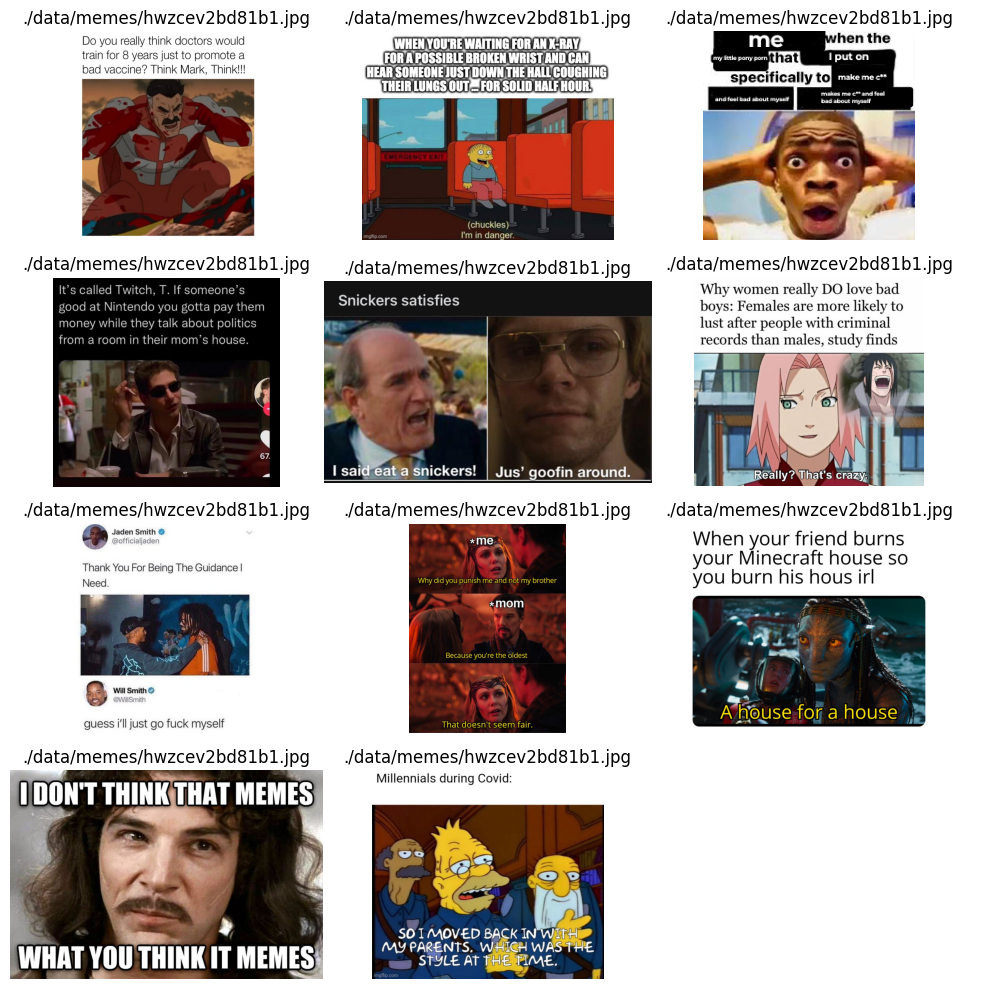

In [100]:
subplots(c1)

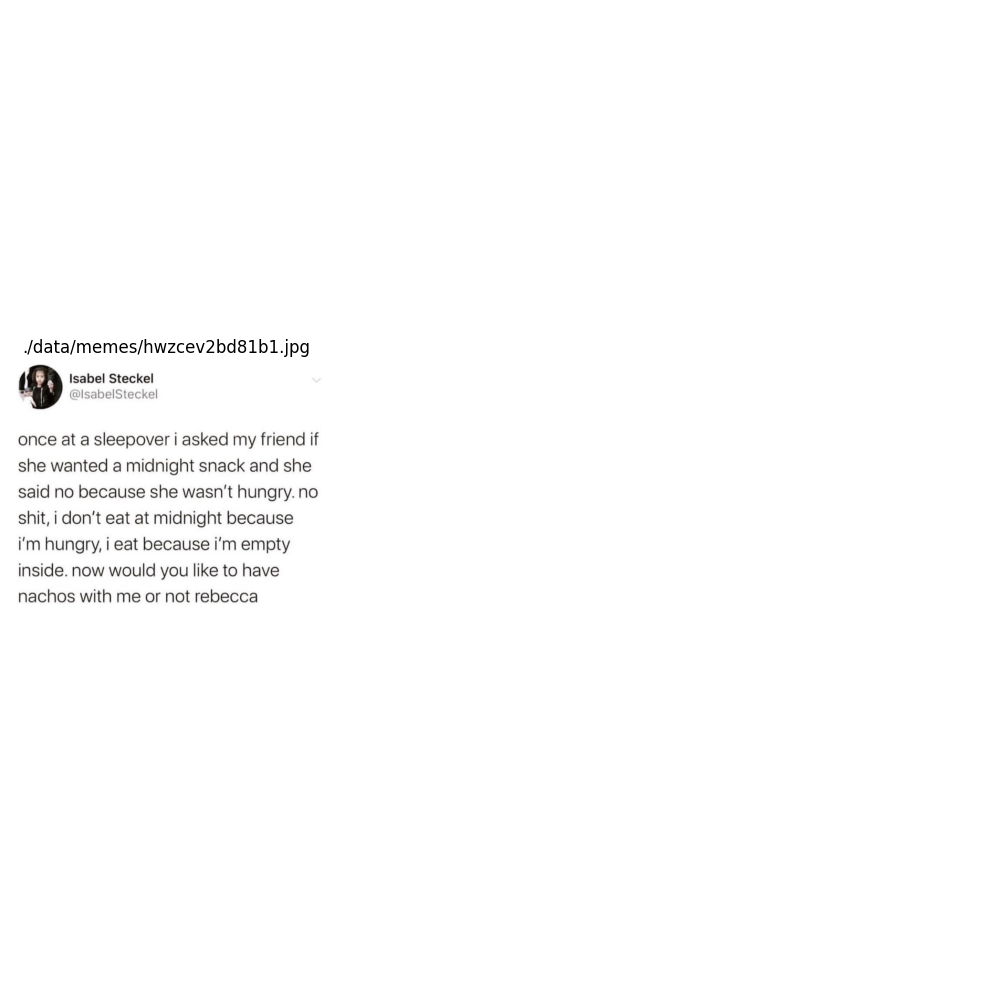

In [102]:
subplots(c2)